<img style="float: right; height: 80px;" src="../_static/ENGAGE.png">

# 2.3. Figure 3 - Net-zero CO2 emissions systems

<a href="https://github.com/iiasa/ENGAGE-netzero-analysis/blob/main/LICENSE">
<img style="float: left; height: 30px; padding: 5px; margin-top: 8px; " src="https://img.shields.io/github/license/iiasa/ENGAGE-netzero-analysis">
</a>

Licensed under the [MIT License](https://github.com/iiasa/ENGAGE-netzero-analysis/blob/main/LICENSE).

This notebook is part of a repository to generate figures and analysis for the manuscript

> Keywan Riahi, Christoph Bertram, Daniel Huppmann, et al. <br />
> Cost and attainability of meeting stringent climate targets without overshoot <br />
> **Nature Climate Change**, 2021 <br />
> doi: [10.1038/s41558-021-01215-2](https://doi.org/10.1038/s41558-021-01215-2)

The scenario data used in this analysis should be cited as

> ENGAGE Global Scenarios (Version 2.0) <br />
> doi: [10.5281/zenodo.5553976](https://doi.org/10.5281/zenodo.5553976)

The data can be accessed and downloaded via the **ENGAGE Scenario Explorer** at [https://data.ece.iiasa.ac.at/engage](https://data.ece.iiasa.ac.at/engage).<br />
*Please refer to the [license](https://data.ece.iiasa.ac.at/engage/#/license)
of the scenario ensemble before redistributing this data or adapted material.*

The source code of this notebook is available on GitHub
at [https://github.com/iiasa/ENGAGE-netzero-analysis](https://github.com/iiasa/ENGAGE-netzero-analysis).<br />
A rendered version can be seen at [https://data.ece.iiasa.ac.at/engage-netzero-analysis](https://data.ece.iiasa.ac.at/engage-netzero-analysis).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyam

from utils import get_netzero_data

<IPython.core.display.Javascript object>

## Import the scenario snapshot used for this analysis and the plotting configuration

In [2]:
data_folder = Path("../data/")

output_folder = Path("output")
output_format = "png"
plot_args = dict(facecolor="white", dpi=300)

In [3]:
rc = pyam.run_control()
rc.update("plotting_config.yaml")

In [4]:
df = pyam.IamDataFrame(data_folder / "ENGAGE_fig3.xlsx")

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/ENGAGE_fig3.xlsx
pyam.core - INFO: Reading meta indicators


Panels a, b, d and e in this figure use the same scenario.

In [5]:
scenario = "EN_NPi2020_1000"

Apply renaming for nicer plots.

In [6]:
df.rename(model=rc["rename_mapping"]["model"], inplace=True)
df.rename(region=rc["rename_mapping"]["region"], inplace=True)

In [7]:
model_format_mapping = {
    "MESSAGEix-GLOBIOM": "MESSAGEix-\nGLOBIOM",
}

def format_model_name(i, model_format_mapping):
    name = i.get_text()
    for key, value in model_format_mapping.items():
        name = name.replace(key, value)

    return name

## Prepare CO2 emissions data

Aggregate two categories of "Other" emissions to show as one category.

In [8]:
components = [f"Emissions|CO2|{i}" for i in ["Other", "Energy|Demand|Other"]]
df_other = df.aggregate(variable="Emissions|CO2|Other", components=components)
df = df.filter(variable=components, keep=False).append(df_other)

In [9]:
sectors_mapping = {
    "AFOLU": "AFOLU",
    "Energy|Demand": "Energy Demand",
    "Energy|Demand|Industry": "Industry",
    "Energy|Demand|Transportation": "Transportation",
    "Energy|Demand|Residential and Commercial": "Buildings",
    "Energy|Supply": "Energy Supply",
    "Industrial Processes": "Industrial Processes",
    "Other": "Other"
}

# explode short dictionary-keys to full variable string
for key in list(sectors_mapping):
    sectors_mapping[f"Emissions|CO2|{key}"] = sectors_mapping.pop(key)

df.rename(variable=sectors_mapping, inplace=True)
sectors = list(sectors_mapping.values())

The REMIND model does not reach net-zero CO2 emissions before the end of the century in the selected scenario
used in Panels a, b, d and e.

It is therefore excluded from this notebook.

In [10]:
df_sector = (
    df.filter(region="World", scenario=scenario, variable=sectors)
    .filter(variable="Energy Demand", keep=False)  # show disaggregation of demand sectors
    .filter(model="REMIND*", keep=False)
    .convert_unit("Mt CO2/yr", "Gt CO2/yr")
)

## Panel a - Development of emissions by sector in one illustrative model

In [11]:
model="MESSAGEix-GLOBIOM"

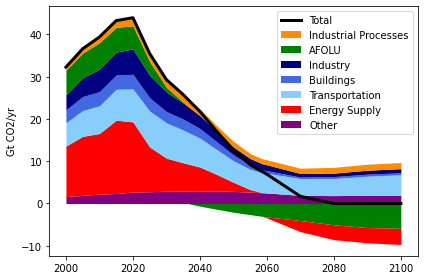

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

(
    df_sector.filter(model=model)
    .plot.stack(ax=ax, title=None, total=dict(lw=3, color="black"))
)

ax.set_xlabel(None)
plt.legend(loc=1)

plt.tight_layout()
fig.savefig(output_folder / f"fig3a_sectoral.{output_format}", **plot_args)

## Panel b - Emissions by sector in the year of net-zero

The function `get_netzero_data` is defined in the file `utils.py` in this folder.

In [13]:
df_netzero_sector = get_netzero_data(df_sector, "netzero|CO2", default_year=2100)

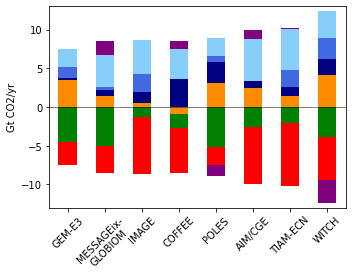

In [14]:
fig, ax = plt.subplots(figsize=(5, 4))

df_netzero_sector.plot.bar(ax=ax, x="model", title=None, stacked=True, legend=False)
ax.axhline(0, color="black", linewidth=0.5)

plt.xlabel(None)
ax.set_xticklabels([format_model_name(i, model_format_mapping) for i in ax.get_xticklabels()])

plt.xticks(rotation=45)
ax.set_ylim(-13, 13)

plt.tight_layout()
fig.savefig(output_folder / f"fig3b_sectoral_year_netzero.{output_format}", **plot_args)

## Panel c - Timing of net-zero CO2 emissions for different sectors

The timing of net-zero for different sectors relative to the timing of net-zero global total CO2 (blue line at zero). The histograms include all pathways that limit temperature to <2 °C.

In [15]:
budget_groups = [600, 900, 1200]

def budget_classification(x):
    for b in budget_groups:
        if x < b:
            return f"below {b} Gt"
    return np.nan

df.set_meta(meta=df.meta["cumulative_emissions_2100"].apply(budget_classification),
            name="budget_range")

In [16]:
def _cross_threshold(x):
    y = pyam.cross_threshold(x, threshold=10)  # the unit is Mt CO2
    return y[0] if len(y) else np.inf

def calculate_netzero(_df):
    cross = _df.apply(_cross_threshold, raw=False, axis=1)
    cross.index = cross.index.droplevel(["region", "variable", "unit"])
    return cross

In [17]:
cols = ["category", "category_peak", "budget_type", "budget_range", "scenario_family", "cumulative_emissions_2100"]

df_sector_nz = df.filter(region="World", variable=sectors, category_peak=["1.5C (with low overshoot)", "2C"])

netzero_sector = df_sector_nz.meta[cols]

In [18]:
for v in sectors:
    _co2 = df_sector_nz.filter(variable=v).timeseries()
    netzero_sector[v] = calculate_netzero(_co2) - df_sector_nz.meta["netzero|CO2"]

x = netzero_sector.set_index(cols, append=True).stack().reset_index().rename(columns={0: "value", "level_8": "sector"})

/var/folders/5h/q1v5dh_d1gx94zmd0rlvysgh0000gn/T/ipykernel_3098/966498754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netzero_sector[v] = calculate_netzero(_co2) - df_sector_nz.meta["netzero|CO2"]


In [19]:
netzero_bins = [-40, -30, -20, -10, 0, 10, 20, 30, 40, ">2100"]

def assign_nz_bin(x):
    for b in netzero_bins:
        try:
            if x < b:
                return b
        # this approach works as long as only the last item is a string
        except TypeError:
            return b

In [20]:
x["netzero"] = x.value.apply(assign_nz_bin)

In [21]:
is_inf = [np.isinf(v) for v in x.value]
not_inf = np.logical_not(is_inf)

_max = max(x.loc[not_inf, "value"])

x["value_"] = x.value
x.loc[is_inf, "value_"] = _max + 10

The **pyam** package does not support histogram-type plots, so panel d is implemented directly in **seaborn**.

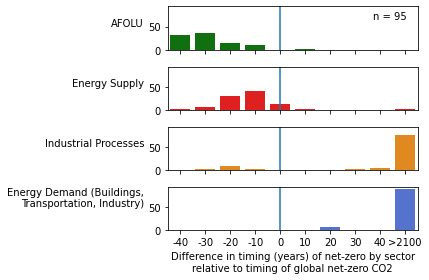

In [22]:
sector_list = ["AFOLU", "Energy Supply", "Industrial Processes", "Energy Demand"]

n = len(sector_list)

fig, ax = plt.subplots(n, 1, figsize=(6, 4), sharex=True, sharey=True)

_x = x[[i in ["1.5C (with low overshoot)", "2C"] for i in x.category_peak]]
_x = _x[_x.scenario_family == "NPi"]

for i, s in enumerate(sector_list):
    sns.countplot(ax=ax[i], data=_x[_x.sector == s], x="netzero", order=netzero_bins,
                  color=rc["color"]["variable"][s])
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(s, rotation=0, horizontalalignment="right")
    ax[i].axvline(x=4)
    
ax[3].set_ylabel("Energy Demand (Buildings,\nTransportation, Industry)",
                 rotation=0, horizontalalignment="right")
ax[3].set_xlabel("Difference in timing (years) of net-zero by sector\nrelative to timing of global net-zero CO2",)

pyam.plotting.set_panel_label(f"n = {len(_x[_x.sector == s])}", ax=ax[0], x=0.82, y=0.7)

plt.tight_layout()
fig.savefig(output_folder / f"fig3c_sectoral_range_netzero.{output_format}", **plot_args)

## Panel d - Development of emissions by region in one illustrative model

In [23]:
df_regional = (
    df.filter(region="World", keep=False)
    .filter(scenario=scenario, variable="Emissions|CO2")
    .filter(model="REMIND*", keep=False)
    .convert_unit("Mt CO2/yr", "Gt CO2/yr")
)

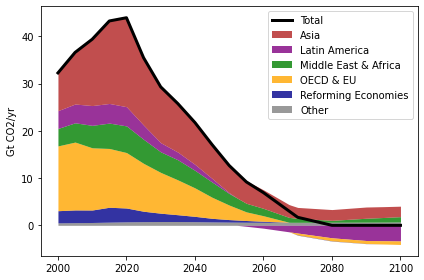

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

(
    pyam.IamDataFrame(
        df_regional.filter(model=model)
        .timeseries()
        .fillna(0)
     ).plot.stack(ax=ax, stack="region", title=None, alpha=0.8, total=dict(lw=3))
)

plt.legend(loc=1)
ax.set_xlabel(None)

plt.tight_layout()
fig.savefig(output_folder / f"fig3d_regional.{output_format}", **plot_args)

## Panel e - Emissions by region in the year of net-zero

The function `get_netzero_data` is defined in the file `utils.py` in this folder.

In [25]:
df_netzero_regional = get_netzero_data(df_regional, "netzero|CO2", default_year=2100)

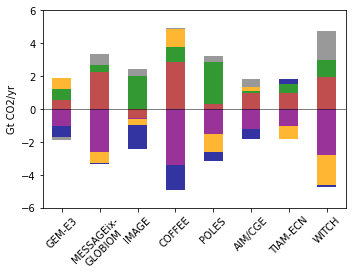

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))

df_netzero_regional.plot.bar(ax=ax, x="model", bars="region", stacked=True, alpha=0.8, title=None, legend=False)

ax.axhline(0, color="black", linewidth=0.5)
ax.set_ylim(-6, 6)
ax.set_xticklabels([format_model_name(i, model_format_mapping) for i in ax.get_xticklabels()])
plt.xlabel(None)

plt.xticks(rotation=45)

plt.tight_layout()
fig.savefig(output_folder / f"fig3e_regional_year_netzero.{output_format}", **plot_args)

## Panel f - Timing of net-zero CO2 emissions for different regions

The timing of net-zero for different regions relative to the timing of net-zero global total CO2 (blue line at zero). The histograms include all pathways that limit temperature to <2 °C.

In [27]:
cols = ["category", "budget_type", "budget_range", "scenario_family", "cumulative_emissions_2100"]

df_region_nz = (
    df.filter(region="World", keep=False).filter(variable="Emissions|CO2")
)

netzero_region = df_region_nz.meta[cols].copy()

In [28]:
for r in df_region_nz.region:
    if r == "Other":
        continue
    
    _co2 = df_region_nz.filter(region=r).timeseries()
    netzero_region[r] = calculate_netzero(_co2) - df_region_nz.meta["netzero|CO2"]

x = netzero_region.set_index(cols, append=True).stack().reset_index().rename(columns={0: "value", "level_7": "region"})

In [29]:
x["netzero"] = x.value.apply(assign_nz_bin)

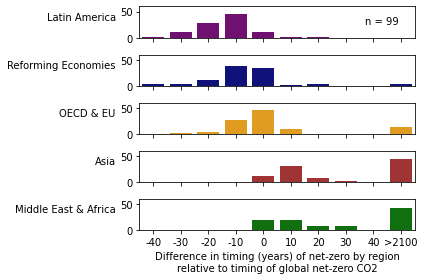

In [30]:
regions = ["Latin America", "Reforming Economies", "OECD & EU", "Asia", "Middle East & Africa"]

n = len(regions)

fig, ax = plt.subplots(n, 1, figsize=(6, 4), sharex=True, sharey=True)

_x = x[[i in ["1.5C (with low overshoot)", "2C"] for i in x.category]]
_x = _x[_x.scenario_family == "NPi"]

for i, r in enumerate(regions):
    sns.countplot(ax=ax[i], data=_x[_x.region == r], x="netzero", order=netzero_bins,
                  color=rc["color"]["region"][r])
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(r, rotation=0, horizontalalignment="right")
    plt.tight_layout()

pyam.plotting.set_panel_label(f"n = {len(_x[_x.region == r])}", ax=ax[0], x=0.82, y=0.55)

ax[4].set_ylim(0, 60)
ax[4].set_xlabel("Difference in timing (years) of net-zero by region\nrelative to timing of global net-zero CO2")

plt.tight_layout()
fig.savefig(output_folder / f"fig3f_regional_range_netzero.{output_format}", **plot_args)